# Table of contents
 1. [Introduction](#Introduction)
     1. [About](#About)
     1. [Setup](#Setup)
     1. [Brief theoretical overview](#Brief-theoretical-overview)
     1. [A note about Effective Sample Size](#A-note-about-Effective-Sample-Size)
 1. [Random Walk Metropolis](#Random-Walk-Metropolis)
     1. [Analysis](#Analysis)
 1. [Improvement: Preconditionned Crank-Nicholson](#Improvement:-Preconditionned-Crank-Nicholson)
     1. [Analysis](#Analysis)
 1. [Laplace approximation with BFGS](#Laplace-approximation-with-BFGS)
     1. [Optimization - MAP & Hessian approximation](#Optimization---MAP-&-Hessian-approximation)
     1. [Independent sampler](#Independent-sampler)
     1. [Analysis](#Analysis)
     1. [MCMC Estimator of scalar quantity](#MCMC-Estimator-of-scalar-quantity)
         1. [Analysis](#Analysis)

# Introduction

## About

This notebook gathers the code used for the miniproject "Bayesian Inverse Problems in Large Dimensions" of the Stochastic Simulation course. See the report for theoretical details.

## Setup

In [1]:
# Google Colab compatibility
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd gdrive/MyDrive/mcmc-inverse-bayesian
except ModuleNotFoundError:
    pass

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Standard libraries
from glob import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# For multiprocessing
import multiprocessing as mp
import itertools

In [32]:
# Override matplotlib defaults for nicer plots
sns.set(style='whitegrid')
# Make plots more latex-like looking
matplotlib.rcParams.update({
    'backend': 'ps',
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{gensymb}',
})
# Increase font size
SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 14, 16, 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
def process_figure(filename):
    """Prettify figure (e.g. despine and make it latex-like) and save it to file"""
    sns.despine()
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight')

In [6]:
# Custom imports
from utils import G, target_density
from mcmc import rwmh, diagnose_plot, ESS
from utils import dump_simulation_results, load_simulation_results

In [7]:
# Given data
y = np.array([0.5041, 0.8505, 1.2257, 1.4113])

In [8]:
# Noise standard deviation
sigma_noise = 0.04
# Chain length
N = int(1e4)

## Brief theoretical overview

We're interested in solving the inverse Bayesian problem

$$\mathbf y = G(\mathbf \theta) + \mathbf \epsilon, \quad \mathbf \epsilon \sim \mathcal N(\mathbf 0, \Sigma_{\mathbf \epsilon})$$

with $G : \mathbb R^D \to \mathbb R^d, D \gg d$. In this Bayesian framework, $\mathbf \theta$ is interpreted as a random variable. In order to get a sense of uncertainty about $\mathbf \theta$, we want to get the empirical distribution of $\mathbf \theta$ by sampling from the posterior

$$\tilde \pi (\mathbf \theta | \mathbf y) = \exp\left( -\frac{1}{2\sigma^2} \Vert G(\mathbf \theta) - \mathbf y \Vert_2^2 - \frac 1 2 \sum_{k=1}^D \theta_k^2 k^2 \right) \propto \pi(\mathbf y | \mathbf \theta) \, \pi_0(\mathbf \theta) $$

## A note about Effective Sample Size

In order to monitor quality and efficiency of chain mixing, we will use traceplots, autocorrelation and effective sample size. As will compute the empirical autocorrelation on a single chain, the signal will be quite noisy (also, remember that the higher the lag, the fewer samples were used to compute the corresponding value). Thus, we will truncate the sum in the computation of ESS:

$$\widehat\text{ESS}\{x\} = \frac{N}{1 + 2 \sum_{l=1}^L R_x[l]}$$

Where $L$ must be carefully chosen. One approach is to truncate the sum when $R_x$ becomes negative:

$$L := \min \left\{ l \in \mathbb N \mid R_x[l] < 0 \right\}$$

Let us briefly motivate that. First, we did not design algorithms which yield negative covariances, so negative autocorrelations are not expected beyond noise. Second, we expect the autocorrelation to decay exponentially with the lag, and we expect to have zero autocorrelation for infinite lags as the Markov Chain will forget about very old values.

# Random Walk Metropolis

In this first approach, we use the proposal distribution

$$Q(\mathbf \theta, \cdot) = \mathcal N(\mathbf \theta, s^2 C), \quad C = \text{diag}(1, 2^{-2}, \ldots, D^{-2})$$

where $D$ is the dimension of the state space, being the number of Fourier coefficients used to approximate the log-permeability.

The goal is to generate chains of length $N=10^4$ with different values of $s$ and $D$. Remind that we're trying to probe the efficiency of MCMC for $D \to\infty$. We will use the `rwmh` (Random Walk Metropolis Hastings) utility function:

In [9]:
help(rwmh)

Help on function rwmh in module mcmc:

rwmh(ftilde: Callable, variances: numpy.ndarray, X0: numpy.ndarray, N: int, verbose: bool = True)
    Random Walk Metropolis Hastings, i.e. type of Markov Chain Monte Carlo in continuous state space with Gaussian proposal
    density centered at current state.
    For a multidimensional state space, the components of the proposal samples are independent, i.e. the covariance
    matrix is diagonal.
    :param ftilde: un-normalized target density being the Markov Chain invariant distribution (after normalization)
    :param variances: 1D array of variances for each component of the proposal distribution
    :param X0: starting point of the chain
    :param N: chain length
    :return: Markov Chain of length N



In [10]:
def simulate(args):
    """Perform one simulation, used as map function for multiprocessor pool"""
    D, s = args
    print(f'D = {D}, s = {s}\t', end='')
    X, p_accept = rwmh(
        ftilde=lambda theta: target_density(theta, sigma_noise, y),
        variances=s**2 / np.arange(1, D+1)**2,
        X0=np.zeros(D),
        N=N
    )
    # Only return the first component of the chain, too much data otherwise
    return {
        'X': X[:, 0],
        'D': D,
        's': s,
        'p_accept': p_accept
    }

One can typically run the cell below in Google Colab with appropriate values for `s` and `D` and then import results with `load_simulation_results`:

In [ ]:
D = (10, 100, 1000)
s = (0.05, 0.1, 0.15, 0.2, 0.3, 0.5)
pool = mp.Pool(mp.cpu_count())
data = pool.map(simulate, itertools.product(D, s))
pool.close()
dump_simulation_results(data, 'data/rwmh_1.json.gz')

In [11]:
# Load simulation results
df = pd.concat([
    pd.DataFrame(load_simulation_results(fpath)) for fpath in glob('data/rwmh_*.json.gz')
]).sort_values(['D', 's']).reset_index(drop=True)
# Compute effective sample size
df['ess'] = df.X.apply(ESS)
# View data
df

,X,D,s,p_accept,ess
0,"[0.0, 0.006911115300787071, 0.0087445836319664...",10,0.010,0.975498,3.626273
1,"[0.0, 0.06016228464499908, 0.04784292988217376...",10,0.050,0.884888,13.848823
2,"[0.0, 0.0, 0.16016005545099146, 0.160160055450...",10,0.100,0.750875,24.831944
3,"[0.0, 0.2010949446929186, 0.39952787712380605,...",10,0.150,0.640164,49.029663
4,"[0.0, 0.2406491385799963, 0.19137171952869506,...",10,0.200,0.546555,62.945513
5,"[0.0, 0.0, 0.48048016635297436, 0.480480166352...",10,0.300,0.374037,104.332860
6,"[0.0, 0.6703164823097287, 0.6703164823097287, ...",10,0.500,0.182718,92.710885
7,"[0.0, 0.0, 0.1100080998707655, 0.1100080998707...",10,0.600,0.112811,107.680386
8,"[0.0, 0.0, 0.12834278318255973, 0.128342783182...",10,0.700,0.078008,110.688298
9,"[0.0, 0.0, 0.146677466494354, 0.14667746649435...",10,0.800,0.053605,74.810749


## Analysis

Before exploring diagnosis plots, we visualize the acceptance rate and ESS as function of $s$ and dimension $D$:

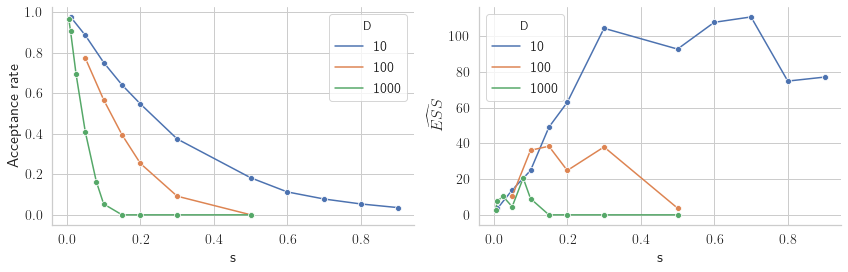

In [33]:
palette = sns.color_palette(n_colors=df.D.nunique())
_, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(x='s', y='p_accept', hue='D', data=df, marker='o', palette=palette, ax=ax[0])
sns.lineplot(x='s', y='ess', hue='D', data=df, marker='o', palette=palette, ax=ax[1])
ax[0].set_ylabel('Acceptance rate')
ax[1].set_ylabel(r'$\widehat{ESS}$')
#ax[0].set_xscale('log')
#ax[1].set_xscale('log')
process_figure('figs/1_rwmh_overview.pdf')

Let's select a few chains for diagnosis plots.
For each dimension $D$, keep two samples: the best chain in terms of ESS, and a chain of average ESS:

In [34]:
keep_idxs = []
for _, subdf in df.groupby('D'):
    subdf = subdf[~subdf.ess.isna()].sort_values('ess', ascending=False)
    # Find "moderate" quality chain with average ESS
    idx_moderate = np.abs(subdf.ess - subdf.ess.median()).argmin()
    # Keep best chain and average-quality chain
    keep_idxs.extend(subdf.index[[0, idx_moderate]])

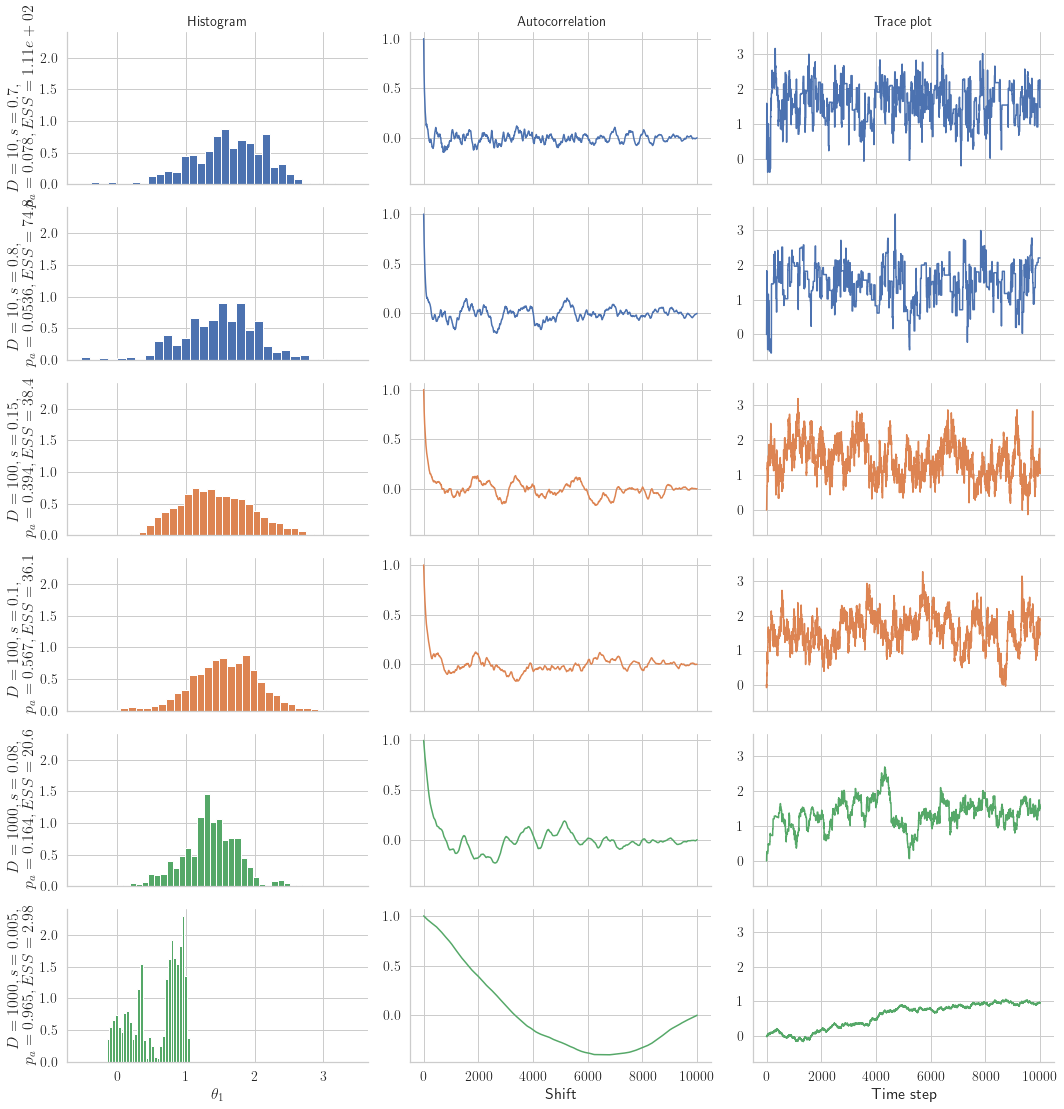

In [36]:
df_diagnosis = df.loc[keep_idxs]
labels = [
    f'$D = {row.D}, s = {row.s}, \\\\ p_a = {row.p_accept:.3}, ESS = {row.ess:.3}$' for _, row in df_diagnosis.iterrows()
]
colors = np.array(palette)[[0, 0, 1, 1, 2, 2]]
diagnose_plot(df_diagnosis.X, labels, r'$\theta_1$', colors=colors)
process_figure('figs/1_rwmh_diag.pdf')

# Improvement: Preconditionned Crank-Nicholson


$$q(\mathbf \theta, \cdot) = \mathcal N(\mathbf \theta \sqrt{1-s^2}, s^2 C)$$

In terms of the implementation, only a slight modification of `rwmh` is required: we just add a `precond_const` argument with value `1.0` by default (i.e., standard random walk metropolis), and we multiply the current state by this `precond_const` when shifting the pre-computed proposals.

In [37]:
from mcmc import pcn

In [41]:
def simulate(args):
    """Perform one simulation, used as map function for multiprocessor pool"""
    D, s = args
    print(f'D = {D}, s = {s}\t', end='')
    X, p_accept = pcn(
        ftilde=lambda theta: np.exp(- 0.5 / sigma_noise**2 * ((y - G(theta)) ** 2).sum()),
        variances=s**2 / np.arange(1, D+1)**2,
        X0=np.zeros(D),
        N=N,
        factor=np.sqrt(1 - s**2)
    )
    # Only return the first component of the chain, too much data otherwise
    return {
        'X': X[:, 0],
        'D': D,
        's': s,
        'p_accept': p_accept
    }

In [43]:
D = (10, 100, 1000)
s = (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99)
pool = mp.Pool(mp.cpu_count())
data = pool.map(simulate, itertools.product(D, s))
pool.close()
dump_simulation_results(data, 'data/pcn_1.json.gz')

D = 10, s = 0.3	D = 10, s = 0.1	D = 10, s = 0.7	D = 10, s = 0.5	D = 10, s = 0.9	D = 100, s = 0.1	took 0.953 s  acceptance rate 0.797
D = 10, s = 0.2	took 1.09 s   acceptance rate 0.241
D = 10, s = 0.6	took 1.17 s   acceptance rate 0.129
D = 10, s = 0.8	took 1.17 s   acceptance rate 0.0563
D = 10, s = 0.99	took 1.42 s   acceptance rate 0.452
D = 10, s = 0.4	took 0.94 s   acceptance rate 0.602
D = 100, s = 0.3	took 1.03 s   acceptance rate 0.0846
D = 100, s = 0.5	took 0.87 s   acceptance rate 0.327
D = 100, s = 0.7	took 1.13 s   acceptance rate 0.0278
D = 100, s = 0.9	took 1.33 s   acceptance rate 0.173
D = 1000, s = 0.1	took 6.92 s   acceptance rate 0.787
D = 100, s = 0.2	took 6.43 s   acceptance rate 0.433
D = 100, s = 0.4	took 6.96 s   acceptance rate 0.228
D = 100, s = 0.6	took 6.96 s   acceptance rate 0.12
D = 100, s = 0.8	took 7.25 s   acceptance rate 0.0533
D = 100, s = 0.99	took 6.75 s   acceptance rate 0.594
D = 1000, s = 0.3	took 7.21 s   acceptance rate 0.323
D = 1000, s = 0.5

In [44]:
# Load simulation results
df = pd.concat([
    pd.DataFrame(load_simulation_results(fpath)) for fpath in glob('data/pcn_*.json.gz')
]).sort_values(['D', 's']).reset_index(drop=True)
# Compute effective sample size
df['ess'] = df.X.apply(ESS)
# View data
df

,X,D,s,p_accept,ess
0,"[0.0, 0.02930992258741061, 0.02930992258741061...",10,0.10,0.797180,39.337126
1,"[0.0, 0.0, -0.018581679587868608, 0.1805140090...",10,0.20,0.601960,63.468372
2,"[0.0, 0.08792976776223183, 0.08792976776223183...",10,0.30,0.452345,173.405633
3,"[0.0, 0.0, -0.037163359175737216, 0.3633797435...",10,0.40,0.326533,205.150185
4,"[0.0, 0.14654961293705304, 0.14654961293705304...",10,0.50,0.240924,214.726798
5,"[0.0, 0.0, -0.05574503876360582, 0.55156475628...",10,0.60,0.173417,223.161560
6,"[0.0, 0.20516945811187426, 0.20516945811187426...",10,0.70,0.128913,114.514143
7,"[0.0, 0.0, -0.07432671835147443, 0.75028501871...",10,0.80,0.084608,260.714582
8,"[0.0, 0.2637893032866955, 0.2637893032866955, ...",10,0.90,0.056306,182.550532
9,"[0.0, 0.0, 0.0, 0.983665299030522, 0.983665299...",10,0.99,0.027803,116.361532


## Analysis

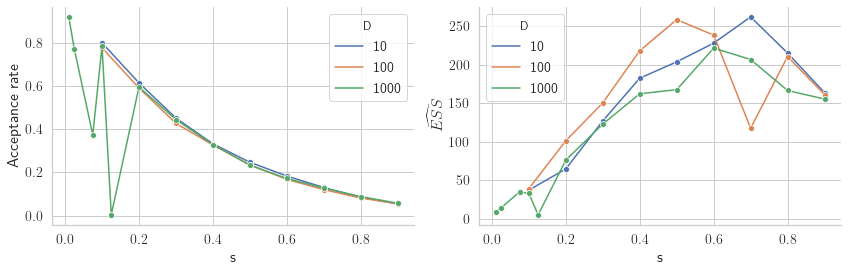

In [40]:
palette = sns.color_palette(n_colors=df.D.nunique())
_, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(x='s', y='p_accept', hue='D', data=df, marker='o', palette=palette, ax=ax[0])
sns.lineplot(x='s', y='ess', hue='D', data=df, marker='o', palette=palette, ax=ax[1])
ax[0].set_ylabel('Acceptance rate')
ax[1].set_ylabel(r'$\widehat{ESS}$')
process_figure('figs/2_pcn_overview.pdf')

In [46]:
keep_idxs = []
for _, subdf in df.groupby('D'):
    subdf = subdf[~subdf.ess.isna()].sort_values('ess', ascending=False)
    # Find "moderate" quality chain with average ESS
    idx_moderate = np.abs(subdf.ess - subdf.ess.median()).argmin()
    # Keep best chain and average-quality chain
    keep_idxs.extend(subdf.index[[0, idx_moderate]])

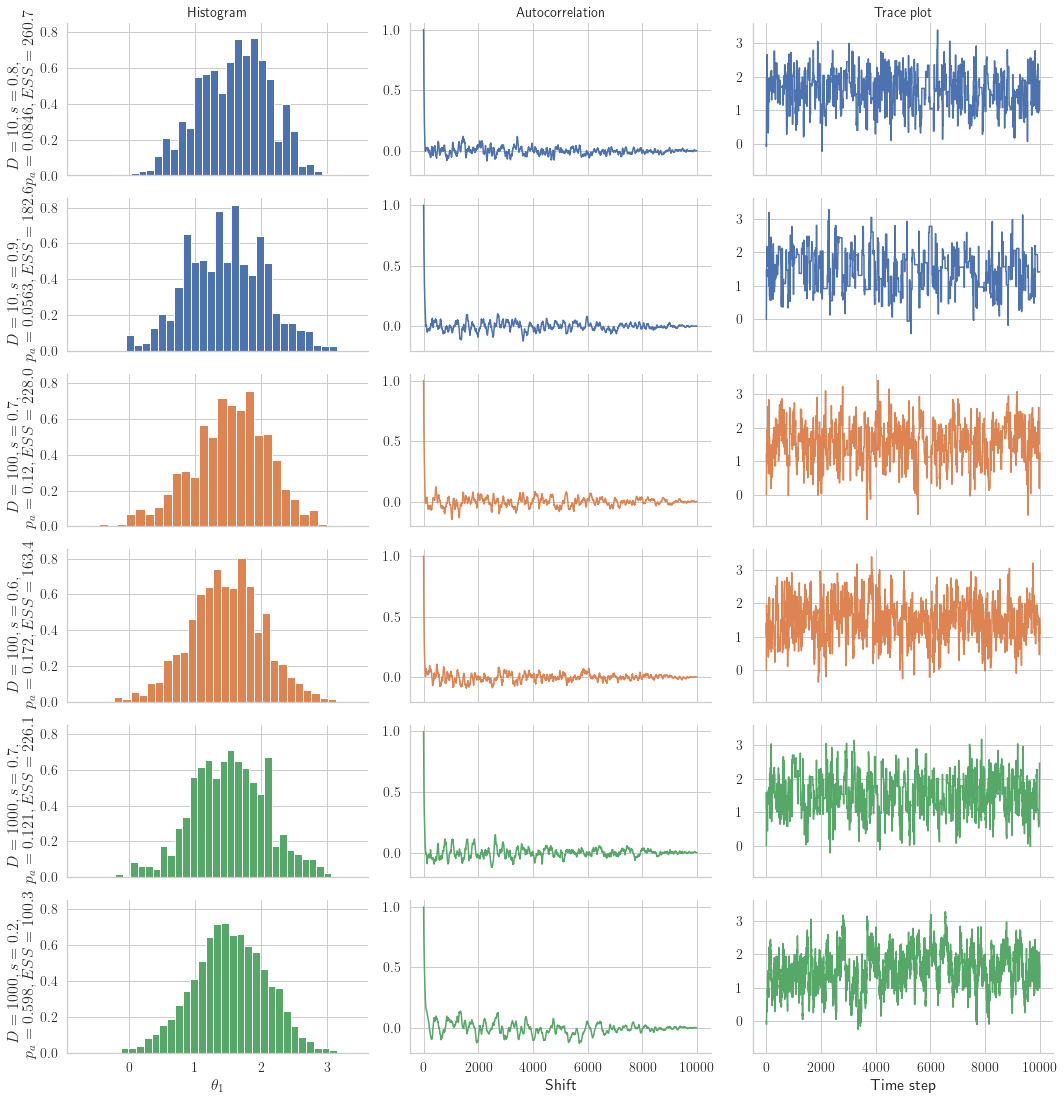

In [47]:
df_diagnosis = df.loc[keep_idxs]
labels = [
    f'$D = {row.D}, s = {row.s}, \\\\ p_a = {row.p_accept:.3}, ESS = {row.ess:.4}$' for _, row in df_diagnosis.iterrows()
]
colors = np.array(palette)[[0, 0, 1, 1, 2, 2]]
diagnose_plot(df_diagnosis.X, labels, r'$\theta_1$', colors=colors)
process_figure('figs/2_pcn_diag.pdf')

# Laplace approximation with BFGS

In [48]:
from utils import u
from mcmc import indep_sampler

In [49]:
import numpy as np
from scipy.optimize import minimize
from scipy import stats
from scipy import integrate
import sympy

In [50]:
import pickle

## Optimization - MAP & Hessian approximation

We want to solve the optimization problem:

$$\begin{align}
\theta_\text{MAP} &= \text{arg}\min_{\mathbf \theta \in \mathbb R^D} -\log \pi(\mathbf \theta | \mathbf y)\\
&= \text{arg}\min_{\mathbf \theta \in \mathbb R^D} -\log \widetilde \pi(\mathbf \theta | \mathbf y)
\end{align}$$

with an optimization algorithm that includes 2nd order information, so that we have a lower rank approximation of the Hessian $\tilde H$. Note that

$$- \log \widetilde \pi (\mathbf \theta | \mathbf y) = \frac{1}{2\sigma^2} \Vert G(\mathbf \theta) - \mathbf y \Vert_2^2 + \frac 1 2 \sum_{k=1}^D \theta_k^2 k^2 \; ,$$


In [51]:
# Define minus log of posterior
min_log_post = lambda theta: (0.5 / sigma_noise**2 * ((y - G(theta)) ** 2).sum() + 0.5 * ( (theta * np.arange(1, theta.size+1))**2 ).sum())


Note that calling the `scipy.optimize.minimize` function with $D=1000$ dimensions never returns, so we will limite ourselves to $D=10, 100$.

In [ ]:
data_optim = dict()
for D in (10, 50, 100, 200):
    print(f'computing D={D}')
    res = minimize(
        min_log_post, x0=np.zeros(D), method='BFGS'
    )
    data_optim[D] = res

with open('data/data_optim.pickle', 'wb') as f:
    pickle.dump(data_optim, f)

In [52]:
with open('data/data_optim.pickle', 'rb') as f:
    data_optim = pickle.load(f)

As a quick sanity check, compare the first few components:

In [53]:
# Sanity check
for D, res in data_optim.items():
    print(f'D={D:<5}', end=' ')
    for dim in range(1, 5):
        print(f'theta_{dim} = {f"{res.x[dim]:.5}":<15}', end='')
    print()

D=10    theta_1 = -0.18149       theta_2 = -0.036883      theta_3 = 0.19017        theta_4 = -0.18913       
D=50    theta_1 = -0.1841        theta_2 = -0.041508      theta_3 = 0.18825        theta_4 = -0.19462       
D=100   theta_1 = -0.18419       theta_2 = -0.041649      theta_3 = 0.18817        theta_4 = -0.19477       
D=200   theta_1 = -0.18421       theta_2 = -0.041684      theta_3 = 0.18815        theta_4 = -0.19481       


## Independent sampler

In [54]:
N = int(1e4)

def simulate(args, keep_first_component=True):
    """Perform one simulation, used as map function for multiprocessor pool"""
    D, alpha = args
    print(f'D = {D}, alpha = {alpha}\t', end='')
    distribution = stats.multivariate_normal(
        mean=data_optim[D].x,
        cov=data_optim[D].hess_inv + alpha**2 * np.eye(D)
    )
    X, p_accept = indep_sampler(
        ftilde=lambda theta: target_density(theta, sigma_noise, y),
        proposal_density=distribution.pdf,
        proposal_sampler=distribution.rvs,
        X0=np.zeros(D),
        N=N
    )
    # Only return the first component of the chain, too much data otherwise
    if keep_first_component:
        X = X[:, 0]
    return {
        'X': X,
        'D': D,
        'alpha': alpha,
        'p_accept': p_accept
    }

In [ ]:
D = (10, 100, )
alpha = (1e-7, 1e-6, 1e-5)
#alpha = np.logspace(-3, -2, 5)[1:-1]
#alpha = (0.0001, 0.001, 0.01, 0.1)
pool = mp.Pool(mp.cpu_count())
data = pool.map(simulate, itertools.product(D, alpha))
pool.close()
dump_simulation_results(data, 'data/lapl_4.json.gz')

In [55]:
# Load simulation results
df = pd.concat([
    pd.DataFrame(load_simulation_results(fpath)) for fpath in glob('data/lapl_*.json.gz')
]).sort_values(['D', 'alpha']).reset_index(drop=True)
# Compute effective sample size
df['ess'] = df.X.apply(ESS)
# Discard when alpha < 1e-5 since constant plateau
df = df[df.alpha >= 1e-5]
# View data
df

,X,D,alpha,p_accept,ess
2,"[0.0, 1.7388036035333916, 1.111970868121326, 2...",10,0.000010,0.882088,2735.475545
3,"[0.0, 1.7388036015942832, 1.1119708623244173, ...",10,0.000100,0.882088,2735.475542
4,"[0.0, 1.738803407690763, 1.1119702826299414, 2...",10,0.001000,0.882088,2735.475243
5,"[0.0, 1.738784089638171, 1.1119122778815935, 2...",10,0.010000,0.882188,2709.430355
6,"[0.0, 0.0, 1.0499110612463083, 2.2255665054910...",10,0.100000,0.442844,1320.550561
7,"[0.0, 0.0, 1.056433300939186, 2.22491417529772...",10,0.177828,0.113011,311.501602
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.1828767501476172, ...",10,0.316228,0.008701,47.028421
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10,0.562341,0.000500,10.273510
10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10,1.000000,0.000000,0.000000
13,"[0.0, 1.779101601389639, 0.9380989566602727, 1...",100,0.000010,0.866187,2862.681296


## Analysis

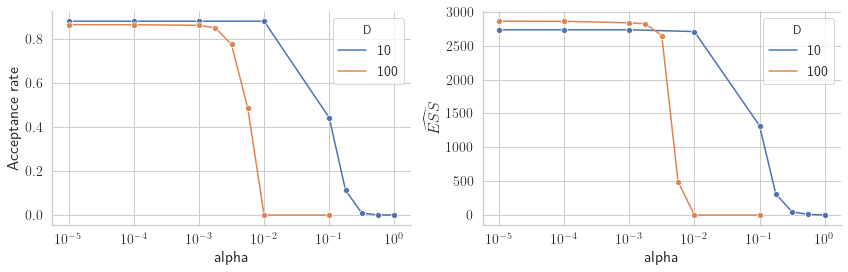

In [56]:
palette = sns.color_palette(n_colors=df.D.nunique())
_, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(x='alpha', y='p_accept', hue='D', data=df, marker='o', palette=palette, ax=ax[0])
sns.lineplot(x='alpha', y='ess', hue='D', data=df, marker='o', palette=palette, ax=ax[1])
ax[0].set_xscale('log'); ax[1].set_xscale('log')
ax[0].set_ylabel('Acceptance rate')
ax[1].set_ylabel(r'$\widehat{ESS}$')
process_figure('figs/3_lapl_overview.pdf')

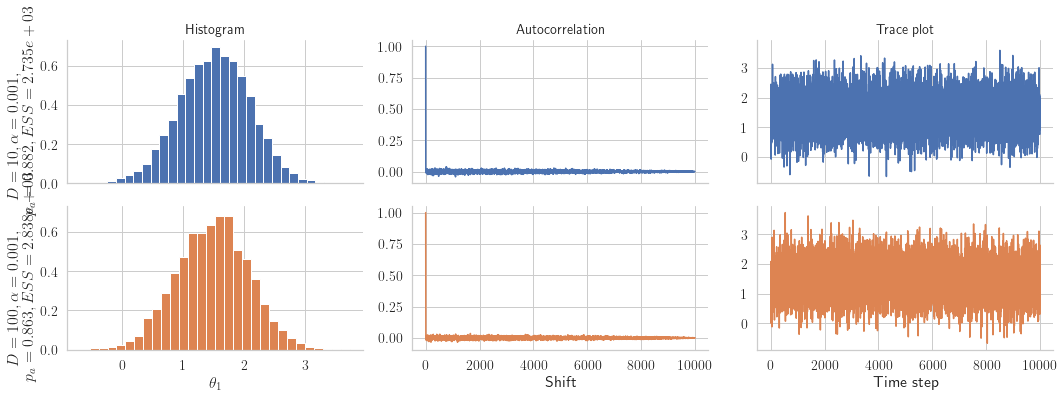

In [57]:
df_diagnosis = df[df.alpha==1e-3]
labels = [
    f'$D = {row.D}, \\alpha = {row.alpha:.3}, \\\\ p_a = {row.p_accept:.3}, ESS = {row.ess:.4}$' for _, row in df_diagnosis.iterrows()
]
diagnose_plot(df_diagnosis.X, labels, r'$\theta_1$', colors=np.array(palette)[[0, 1]])
process_figure('figs/3_lapl_diagnosis.pdf')

## MCMC Estimator of scalar quantity

Eventually we want to compute the expected value of the following quantity

$$\mathbb E_{\theta\sim\pi(\mathbf \cdot \mid \mathbf y)}[I(\mathbf\theta)], \quad I(\mathbf \theta) := \int_0^1 e^{u(x; \, \mathbf\theta)} dx$$



In [58]:
def compute_quantity(theta):
    # Discretization step
    h = 1 / (2*theta.size)
    # Grid at which we evaluate integrand
    x = np.arange(0, 1+h, h)
    # Integrand
    y = np.exp(u(x, theta))
    # Integrate with trapezoidal method
    trpz = integrate.trapz(y, x)
    return trpz

We define another routine which we'll provide the the multiprocessor pool, which re-uses the above `simulate` function:

In [59]:
def simulate_and_compute_quantity(args):
    res = simulate(args, keep_first_component=False)
    res['quantity_mcmc'] = np.mean([compute_quantity(theta) for theta in res['X']])
    del res['X']
    return res

In [ ]:
D = (10, 100)
alpha = (1e-4, 1e-3, 1e-2, 1e-1, 1.)
pool = mp.Pool(mp.cpu_count())
data = pool.map(simulate_and_compute_quantity, itertools.product(D, alpha))
pool.close()

df_qtty = pd.DataFrame(data)
df_qtty.to_csv('data/data_mcmc_estimator.csv', index=False)

### Analysis

In [60]:
df_qtty = pd.read_csv('data/data_mcmc_estimator.csv')
df_qtty

,D,alpha,p_accept,quantity_mcmc
0,10,0.0001,0.875088,1.619945
1,10,0.0010,0.875088,1.619946
2,10,0.0100,0.877188,1.619653
3,10,0.1000,0.440144,1.621893
4,10,1.0000,0.000000,1.000000
5,100,0.0001,0.870487,1.611685
6,100,0.0010,0.876288,1.616725
7,100,0.0100,0.000000,1.000000
8,100,0.1000,0.000000,1.000000
9,100,1.0000,0.000000,1.000000
